In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.mlab import griddata

In [2]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [3]:
num_samples = 50000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)

In [4]:
import tensorflow as tf

In [5]:
import tensorflow.contrib.layers as layers

In [6]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [7]:
# batch size for evaluation of mutual entropy
MINE_batch_size = num_samples

# batch size for the training of the encoder / classifier pair
batch_size = 200

bottleneck_size = 2

In [8]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
nuisances_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisances_in')
labels_in = tf.placeholder(tf.int32, [None, ], name = 'labels_in')

In [9]:
def encoder(encoder_input):
    with tf.variable_scope("encoder"):
        lay = layers.relu(encoder_input, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, bottleneck_size)
        
        these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "encoder")
        
    return outputs, these_vars

In [10]:
def classifier(classifier_input):
    with tf.variable_scope("classifier"):
        lay = layers.relu(classifier_input, 5)
        lay = layers.relu(lay, 5)
        lay = layers.relu(lay, 2)
        outputs = layers.softmax(lay)
        
        these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "classifier")

    return outputs, these_vars

In [11]:
def MINE_network(data):
    with tf.variable_scope("MINE"):
        lay = layers.relu(data, 20)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = "MINE")
    
    return outputs, these_vars

In [12]:
encoded, encoder_vars = encoder(data_in)

In [13]:
classifier_output, classifier_vars = classifier(encoded)

In [14]:
nuisances_shuffled = tf.random.shuffle(nuisances_in)

In [15]:
# prepare input for MINE
#data_x_combined = tf.concat([encoded, encoded], axis = 0)
data_x_combined = tf.concat([classifier_output, classifier_output], axis = 0)
data_y_combined = tf.concat([nuisances_in, nuisances_shuffled], axis = 0)

In [16]:
data_combined = tf.concat([data_x_combined, data_y_combined], axis = 1)
MINE_output, MINE_vars = MINE_network(data_combined)

In [17]:
batch_size_dyn = tf.cast(tf.math.divide(tf.shape(MINE_output)[0], 2), tf.int32)

In [18]:
T_xy = MINE_output[:batch_size_dyn,:]
T_x_y = MINE_output[batch_size_dyn:,:]
MINE_loss = -(tf.reduce_mean(T_xy, axis = 0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y), axis = 0)))
MINE_loss = MINE_loss[0]

In [19]:
labels_one_hot = tf.one_hot(labels_in, depth = 2)

In [20]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = classifier_output)

In [21]:
train_ec_pair = tf.train.AdamOptimizer(learning_rate = 0.005, beta1 = 0.9, beta2 = 0.999).minimize(classification_loss, var_list = classifier_vars + encoder_vars)
#train_ec_pair = tf.train.GradientDescentOptimizer(learning_rate = 0.00001).minimize(classification_loss, var_list = classifier_vars + encoder_vars)

In [22]:
MINE_regularized_classification_loss = classification_loss - MINE_loss

In [23]:
train_ec_pair_MINE_regularized = tf.train.AdamOptimizer(learning_rate = 0.0001, beta1 = 0.3, beta2 = 0.5).minimize(MINE_regularized_classification_loss, var_list = classifier_vars + encoder_vars)
#train_ec_pair_MINE_regularized = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(MINE_regularized_classification_loss, var_list = classifier_vars + encoder_vars)

In [24]:
init_MINE = tf.variables_initializer(var_list = MINE_vars)
train_MINE = tf.train.AdamOptimizer(learning_rate = 0.01, beta1 = 0.3, beta2 = 0.5).minimize(MINE_loss, var_list = MINE_vars)

In [25]:
# combined training
classification_loss_evolution = []
MI_evolution = []
number_batches = 200
MINE_batches = 300

In [26]:
number_epochs = 20

In [27]:
sess.run(tf.global_variables_initializer())

In [28]:
# pre-train MINE
sess.run(init_MINE)
for batch in range(MINE_batches):
    sess.run(train_MINE, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})

print("pre-training complete")
    
for epoch in range(number_epochs):
    print("epoch {}".format(epoch))
    # train new MINE on current encoder output
    
    for batch in range(number_batches):
        # train classifier with MINE regularization
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]
        labels_batch = labels_train[inds]
        nuisances_batch = nuisances_train[inds]

        sess.run(train_MINE, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
        sess.run(train_ec_pair_MINE_regularized, feed_dict = {data_in: data_batch, nuisances_in: nuisances_batch, labels_in: labels_batch})
    
        if not batch % 100:
            MI = -sess.run(MINE_loss, feed_dict = {data_in: data_train, nuisances_in: nuisances_train})
            class_loss = sess.run(classification_loss, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, labels_in: labels_train})
            global_loss = sess.run(MINE_regularized_classification_loss, feed_dict = {data_in: data_train, nuisances_in: nuisances_train, labels_in: labels_train})

            print("MI = {}, class_loss = {}, global_loss = {}".format(MI, class_loss, global_loss))

pre-training complete
epoch 0
MI = 0.0004558563232421875, class_loss = 0.6954308748245239, global_loss = 0.6959003210067749
MI = 3.147125244140625e-05, class_loss = 0.6921756267547607, global_loss = 0.6921977996826172
epoch 1
MI = 0.000255584716796875, class_loss = 0.6876652836799622, global_loss = 0.6878798604011536
MI = 0.00011777877807617188, class_loss = 0.679592490196228, global_loss = 0.679705023765564
epoch 2
MI = 0.0016536712646484375, class_loss = 0.6723936200141907, global_loss = 0.6738017201423645
MI = 0.0022673606872558594, class_loss = 0.6668679714202881, global_loss = 0.669243574142456
epoch 3
MI = 0.0037965774536132812, class_loss = 0.6617004871368408, global_loss = 0.6656591892242432
MI = 0.0037279129028320312, class_loss = 0.6570299863815308, global_loss = 0.66197669506073
epoch 4
MI = 0.0038661956787109375, class_loss = 0.6509453654289246, global_loss = 0.6549879908561707
MI = 0.0034933090209960938, class_loss = 0.6437435746192932, global_loss = 0.646797239780426
epoc

In [29]:
data_test = np.random.uniform(low = -6, high = 6, size = [50000, 2])

In [30]:
pred = sess.run(classifier_output, feed_dict = {data_in: data_test})

/usr/lib/python3/dist-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  app.launch_new_instance()
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


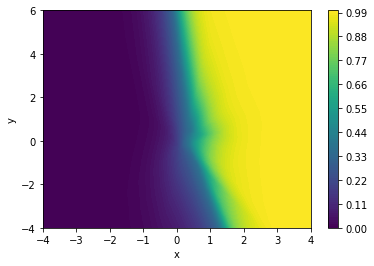

In [31]:
xi = np.linspace(-4, 4, 1000)
yi = np.linspace(-4, 6, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], pred[:, 0], xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 100)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

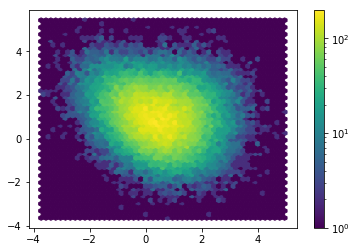

In [32]:
plt.hexbin(x = data_train[:, 0], y = data_train[:, 1], bins = 'log', gridsize = 50)
plt.colorbar()
plt.show()

In [33]:
# check for pivoting property
data_test, labels_test, nuisances_test = prepare_data(num_samples)

In [34]:
group1 = np.logical_and(nuisances_test > 0.0, nuisances_test < 0.5)
group2 = np.logical_and(nuisances_test > 0.5, nuisances_test < 1.0)
group3 = np.logical_and(nuisances_test > 1.0, nuisances_test < 1.5)
group4 = np.logical_and(nuisances_test > 1.5, nuisances_test < 2.0)

In [35]:
pred1 = sess.run(classifier_output, feed_dict = {data_in: data_test[group1]})
pred2 = sess.run(classifier_output, feed_dict = {data_in: data_test[group2]})
pred3 = sess.run(classifier_output, feed_dict = {data_in: data_test[group3]})
pred4 = sess.run(classifier_output, feed_dict = {data_in: data_test[group4]})

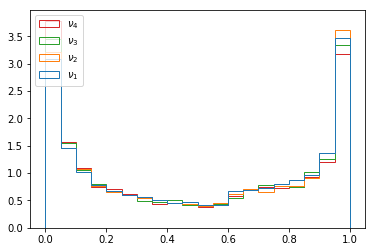

In [40]:
colors = ['red', 'tan', 'lime', 'green']
plt.hist([pred1[:,1], pred2[:,1], pred3[:,1], pred4[:,1]], label = [r'$\nu_1$', r'$\nu_2$', r'$\nu_3$', r'$\nu_4$'], histtype = 'step', density = True, stacked = False, fill = False, bins = 20)
plt.legend(loc = 'upper left')
plt.show()

In [41]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [42]:
pred_sig = sess.run(classifier_output, feed_dict = {data_in: sig})
pred_bkg = sess.run(classifier_output, feed_dict = {data_in: bkg})

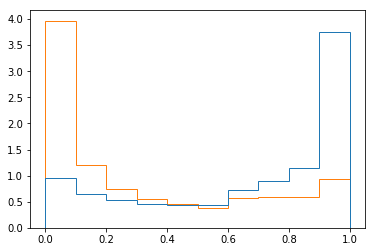

In [43]:
plt.hist([pred_sig[:,1], pred_bkg[:,1]], label = ['sig', 'bkg'], histtype = 'step', density = True, stacked = False, fill = False, bins = 10)
plt.show()